In [14]:
!pip install datasets pandas nltk seaborn

In [16]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", header=None, names=["label", "title", "text"])

In [19]:
df.head()

,label,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [24]:
import spacy
import string
nlp = spacy.load("en_core_web_sm")

In [25]:
def cleanText(text):
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    tokens = [word for word in tokens
              if word not in nlp.Defaults.stop_words
              and word not in string.punctuation
              and word.strip() != ""]
    return " ".join(tokens)

In [26]:
print(df["text"][0])
print(cleanText(df["text"][0]))

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
reuters short seller wall street dwindling\band ultra cynic green


In [28]:
df = df.drop_duplicates()

<ipython-input-30-3453331590>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


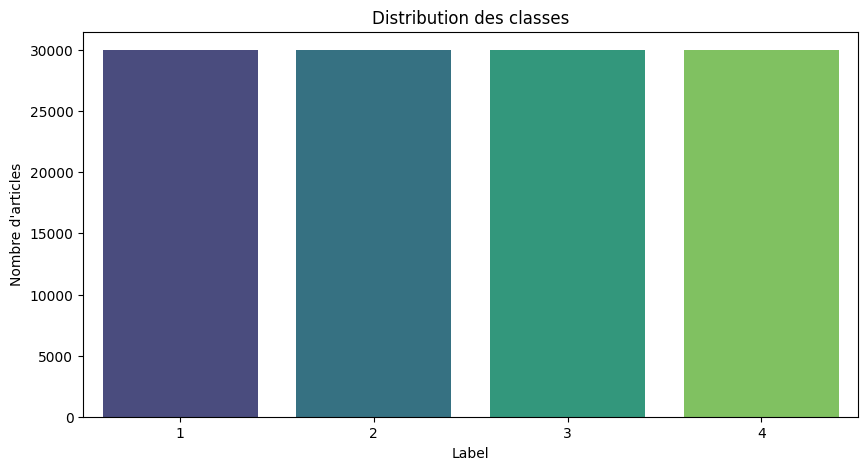

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
# Affiche un barplot de la distribution des classes
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution des classes')
plt.xlabel('Label')
plt.ylabel('Nombre d\'articles')
plt.show()

In [31]:
!pip install transformers torch pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [32]:
from transformers import AutoTokenizer, AutoModel
import torch

# Choix du modèle (bert-base-uncased ou distilbert-base-uncased)
model_name = "distilbert-base-uncased"  # Plus léger et rapide
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [43]:
def generate_embeddings(texts, batch_size=32):
    model.eval()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [45]:
texts = df["title"].tolist()  # ou df["text"] selon ta colonne
embeddings = generate_embeddings(texts[:2000])

print(f"Shape des embeddings : {embeddings[0].shape}")

Shape des embeddings : (768,)


In [47]:
import numpy as np
from sklearn.model_selection import train_test_split

labels = df["label"].values[:len(embeddings)]

X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1600, 768), Test shape: (400, 768)


In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [51]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Définition des noms de classes
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']  # Ordre correspondant aux labels 0,1,2,3

# Prédictions et évaluation
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}\n")

# Rapport avec noms de classes
print("Rapport détaillé :\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=class_names,  # Utilisation des noms explicites
    digits=4  # Nombre de décimales
))

Accuracy: 0.8150
F1-Score (weighted): 0.8152

Rapport détaillé :

              precision    recall  f1-score   support

       World     0.7857    0.8105    0.7979        95
      Sports     0.7838    0.8529    0.8169        68
    Business     0.8000    0.7805    0.7901        82
    Sci/Tech     0.8581    0.8194    0.8383       155

    accuracy                         0.8150       400
   macro avg     0.8069    0.8158    0.8108       400
weighted avg     0.8164    0.8150    0.8152       400



In [74]:
import pandas as pd
import numpy as np

# 1. FORCER les labels à être entre 0 et 3
y_test = np.clip(y_test, 0, 3)  # Remplacer tout label >3 par 3
y_pred = np.clip(y_pred, 0, 3)

# 2. Mapping des classes (AG News standard)
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# 3. Création du DataFrame des résultats
results = pd.DataFrame({
    'text': df['text'].iloc[np.arange(len(y_test))].values,
    'title': df['title'].iloc[np.arange(len(y_test))].values,
    'true_label': y_test,
    'predicted': y_pred
})

# 4. Récupération des erreurs
all_errors = results[results['true_label'] != results['predicted']]

# 5. Affichage des 2 premières erreurs
if not all_errors.empty:
    print("=== 2 Exemples d'erreurs ===")
    for idx, row in all_errors.head(2).iterrows():
        true_name = class_names[row['true_label']]
        pred_name = class_names[row['predicted']]

        print(f"\n{true_name} → {pred_name}")
        print(f"Titre: {row['title']}")
        print(f"Texte: {row['text'][:150]}...")
else:
    print("Aucune erreur trouvée.")

=== 2 Exemples d'erreurs ===

Sci/Tech → Business
Titre: Fed minutes show dissent over inflation (USATODAY.com)
Texte: USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating t...

Sports → Business
Titre: Google IPO faces Playboy slip-up
Texte: The bidding gets underway for Google's public offering, despite last-minute worries over an interview with its bosses in Playboy magazine....


En analysant le F1-score par classe :

World (0.7979) : Performance la plus faible

Business (0.7901) : Deuxième plus faible

Problème principal : Les classes World et Business sont fréquemment confondues (ex: articles sur l'économie mondiale).